In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset 
import sklearn.model_selection as skm
from ISLP import load_data , confusion_table 
from ISLP.models import ModelSpec as MS

In [2]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART

In [3]:
Boston = load_data("Boston")
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [4]:
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

In [5]:
X_train, X_test, y_train, y_test = skm.train_test_split(X, Boston['medv'], test_size=0.3, random_state=0)

#### Regression Tree

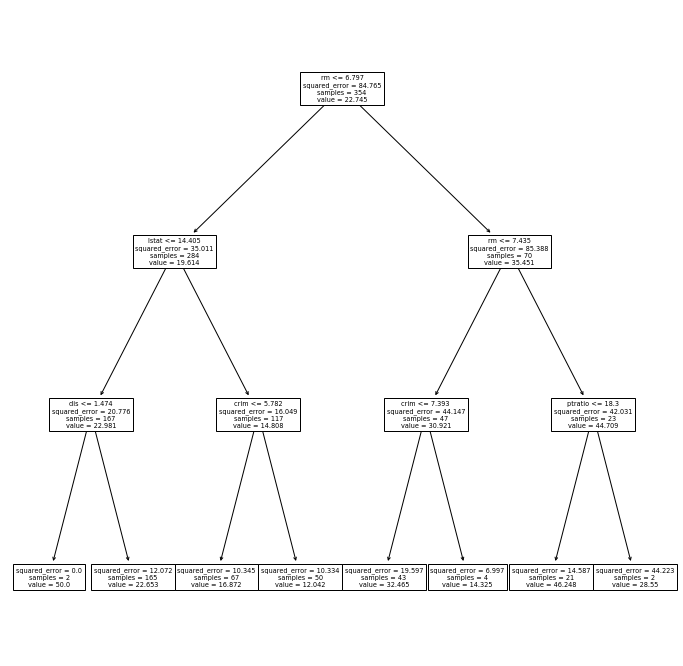

In [7]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);

In [8]:
# use the cross-validation function to see whether pruning the tree will improve performance.
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
ccp_path

{'ccp_alphas': array([ 0.        ,  1.6156522 ,  1.88662474,  3.40178969,  4.17448592,
         8.29259286, 12.98252736, 39.79182618]),
 'impurities': array([12.61901452, 14.23466673, 16.12129147, 19.52308115, 23.69756707,
        31.99015993, 44.97268729, 84.76451347])}

In [9]:
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In [12]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

28.069857549754044

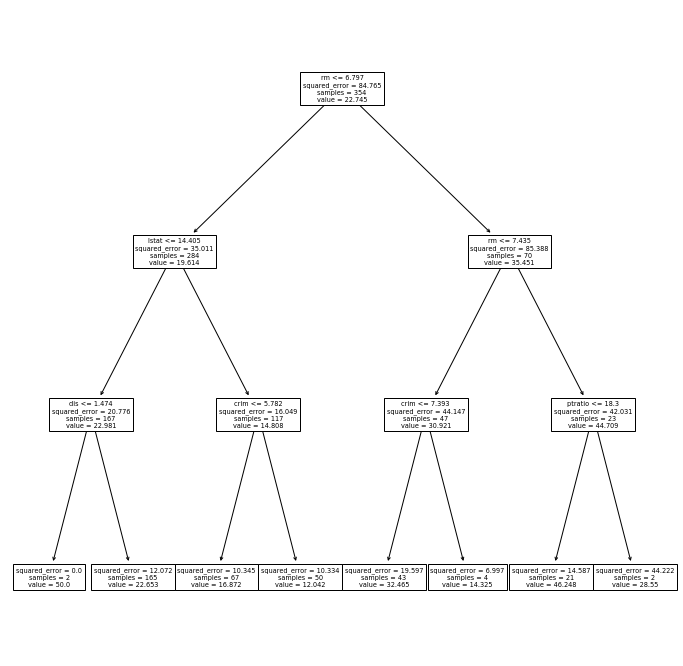

In [13]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);

#### Bagging
Recall that bagging is simply a special case of a random forest with m = p.
Therefore, the RandomForestRegressor() function can be used to perform both bagging and random forests.

In [14]:
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train, y_train)

RandomForestRegressor(max_features=12, random_state=0)

14.634700151315784

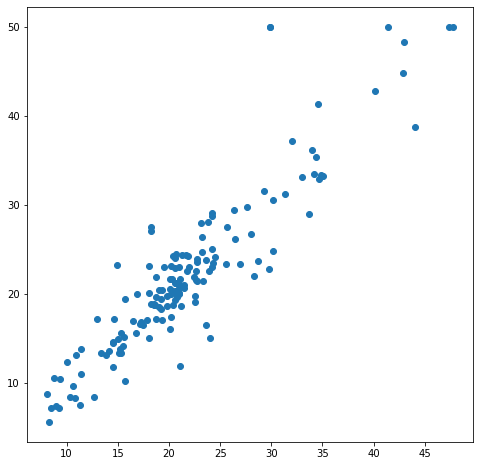

In [15]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)

In [16]:
# change the number of trees grown from the default of 100 by using the n_estimators argument
bag_boston = RF(max_features=X_train.shape[1],
                n_estimators=500,
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

14.605662565263168

not much improvement. Bagging and random forests cannot overfit by increasing the number of trees, but can underfit if the number is too small.

#### Random Forest
By default, RandomForestRegressor() uses variables p when building a random forest of regression trees (i.e. it defaults to bagging), and RandomForestClassifier() uses p^0.5 variables when building a random forest of classification trees.

In [17]:
RF_boston = RF(max_features=6,
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF)**2)

20.04276446710527

In [18]:
# feature importance
feature_imp = pd.DataFrame(
    {'importance':RF_boston.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
lstat,0.356203
rm,0.332163
ptratio,0.067270
crim,0.055404
indus,0.053851
dis,0.041582
nox,0.035225
tax,0.025355
age,0.021506
rad,0.004784


#### Boosting

In [19]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.001,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

We can see how the training error decreases with the train_score_ attribute. To get an idea of how the test error decreases we can use the staged_predict() method to get the predicted values along the path.

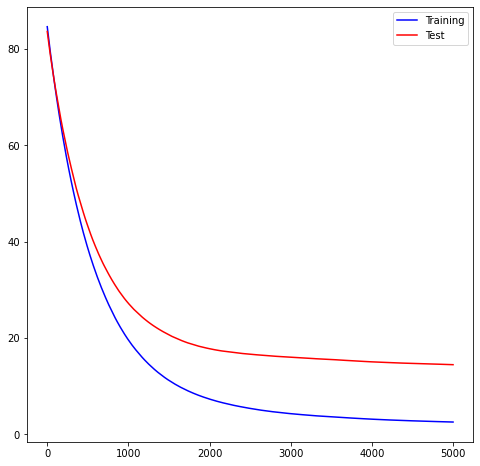

In [20]:
test_error = np.zeros_like(boost_boston.train_score_)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost_boston.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();

In [21]:
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

14.481405918831584

#### Bayesian Additive Regression Trees

In [23]:
bart_boston = BART(random_state=0, burnin=5, ndraw=15)
bart_boston.fit(X_train, y_train)

BART(burnin=5, ndraw=15, random_state=0)

In [24]:
yhat_test = bart_boston.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test)**2)

20.73918541749877

We can check how many times each variable appeared in the collection of trees. This gives a summary similar to the variable importance plot for boosting and random forests.

In [25]:
var_inclusion = pd.Series(bart_boston.variable_inclusion_.mean(0),
                               index=D.columns)
var_inclusion

crim       25.466667
zn         30.600000
indus      24.933333
chas       21.133333
nox        27.333333
rm         28.800000
age        23.466667
dis        26.000000
rad        25.000000
tax        21.733333
ptratio    26.800000
lstat      31.866667
dtype: float64